# 2.1 Unicode

## <font color="red">(a)</font>

In [61]:
chr(0)

'\x00'

## <font color="red">(b)</font>

In [62]:
print(chr(0))

 


In [63]:
l = "this is a test" + chr(0) + "string"
l

'this is a test\x00string'

## <font color="red">(c)</font>

In [64]:
print(l)

this is a test string


# 2.2 Unicode  Encoding

## <font color="red">(a)</font>

In [65]:
# UTF-8编码
"hello".encode("utf-8")  # b'hello' - ASCII字符保持原样
# 每个ASCII字符正好是1字节

# UTF-16编码
"hello".encode("utf-16-le")  # b'h\x00e\x00l\x00l\x00o\x00'
# 每个ASCII字符变为2字节，其中一半是空字节(0x00)

# UTF-32编码
"hello".encode("utf-32-le")  # b'h\x00\x00\x00e\x00\x00\x00l\x00\x00\x00l\x00\x00\x00o\x00\x00\x00'
# 每个ASCII字符变为4字节，其中3/4是空字节

b'h\x00\x00\x00e\x00\x00\x00l\x00\x00\x00l\x00\x00\x00o\x00\x00\x00'

## <font color="red">(b)</font>

原因: 它逐个字节解码UTF-8，而UTF-8字符可能是多字节的.
破坏了多字节序列.UTF-8多字节字符必须作为一个整体解码
,拆分字节会得到完全不同的字符或无效序列.
eg. "你" 的UTF-8编码是 b'\xe4\xbd\xa0'
如果逐个字节解码,会得到:
b'\xe4' -> 'ä'
b'\xbd' -> '½'
b'\xa0' -> ' '
这不是一个有效的UTF-8字符序列,因此会被解码为替换字符(U+FFFD).

In [66]:
def decode_utf8_bytes_to_str_wrong(bytestring: bytes):
    return "".join([bytes([b]).decode("utf-8") for b in bytestring])

string = "hello"
decode_utf8_bytes_to_str_wrong(string.encode("utf-8"))

'hello'

In [67]:
print("你".encode("utf-8"))
print("你".encode("utf-8").decode("utf-8"))

b'\xe4\xbd\xa0'
你


In [68]:
print(b'\xe4'.decode("utf-8"))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 0: unexpected end of data

In [ ]:
string = "你"
decode_utf8_bytes_to_str_wrong(string.encode("utf-8"))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 0: unexpected end of data

## <font color="red">(c)</font>

"中".encode("utf-8")  # b'\xe4\xb8\xad' 是有效的三字节序列
<br>
#但如果拆分：b'\xe4\xb8' 就只有两个字节，但缺少最后一个字节，也是无效的

# 2.4 Pre-tokenization

In [76]:
import regex as re
PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
print(re.findall(PAT, "你好，这是一个测试字符串！"))
print(re.findall(PAT, "some text that i'll pre-tokenize"))

['你好', '，', '这是一个测试字符串', '！']
['some', ' text', ' that', ' i', "'ll", ' pre', '-', 'tokenize']


# 2.5 Experimenting with BPE Tokenizer Training

相比https://github.com/heng380/cs336-assignment1的改进


## 新tokenizer相比旧版本的主要改变和优化



### 1. **注释和文档改进**
- **所有注释中文化**：将英文注释全部替换为中文注释，便于中文用户理解
- **增加详细文档**：为每个函数和类添加了详细的中文文档字符串

### 2. **分块处理优化**
- **换行符规范化**：在`get_chunk`函数中增加了换行符统一处理，将`\r\n`和`\r`都转换为`\n`
- **分割标记更改**：将分块分割标记从`b"<|endoftext|>"`改为`b"\n"`，更符合实际文本分割需求

### 3. **核心算法性能优化**

#### `count_pair_frequencies`方法优化
```python
# 旧版本：每次循环都计算len(word)
for word, freq in tokens_counter.items():
    for i in range(len(word) - 1):

# 新版本：避免重复计算长度，提高性能
for word, freq in tokens_counter.items():
    word_len = len(word)  # 优化：避免重复计算长度
    for i in range(word_len - 1):
```

#### `find_max_pair`方法重写
- **旧版本**：使用`max(counts, key=lambda x: (counts[x], x))`
- **新版本**：手动实现循环比较，避免lambda函数开销，并修复了字典序选择逻辑
- **重要修复**：当频率相同时，选择字典序更大的pair（与原始代码一致）

#### `merge_tokens`方法重大优化
**主要改进：**
- **原地更新**：不再创建新的Counter对象，而是原地更新现有的tokens_counter
- **pair_counts维护**：新增pair_counts参数，在合并时实时更新字节对频率
- **批量操作**：使用tokens_to_remove和tokens_to_add列表进行批量更新
- **性能提升**：避免重复计算pair_counts，显著提高训练速度

### 4. **训练过程优化**

#### `train_BPE`方法改进
- **进程数限制**：`num_processes = min(multiprocessing.cpu_count(), 8)`，避免过度并行化
- **chunksize优化**：使用`chunksize=max(1, len(chunks) // num_processes)`提高并行效率
- **pair_counts单次初始化**：在训练循环外初始化pair_counts，避免重复计算
- **进度条优化**：提前计算目标词汇量，进度条显示更准确

### 5. **Tokenizer类编码优化**
- **移除tqdm进度条**：在`encode`方法中移除了tqdm进度条，提高编码性能
- **保持功能完整性**：所有核心功能保持不变

### 6. **代码结构和可读性改进**
- **类和方法注释**：为所有类和方法添加了详细的中文注释
- **变量命名更清晰**：如`tokens_to_remove`、`tokens_to_add`等变量名更直观
- **代码逻辑分组**：使用中文注释对代码进行逻辑分组

### 性能提升总结

1. **训练速度提升**：通过pair_counts的单次初始化和原地更新，显著减少重复计算
2. **内存效率提升**：避免创建不必要的Counter对象，减少内存分配
3. **并行效率优化**：合理的进程数限制和chunksize设置
4. **算法复杂度优化**：减少重复的长度计算和字典操作

        

## 在tinystories上的训练

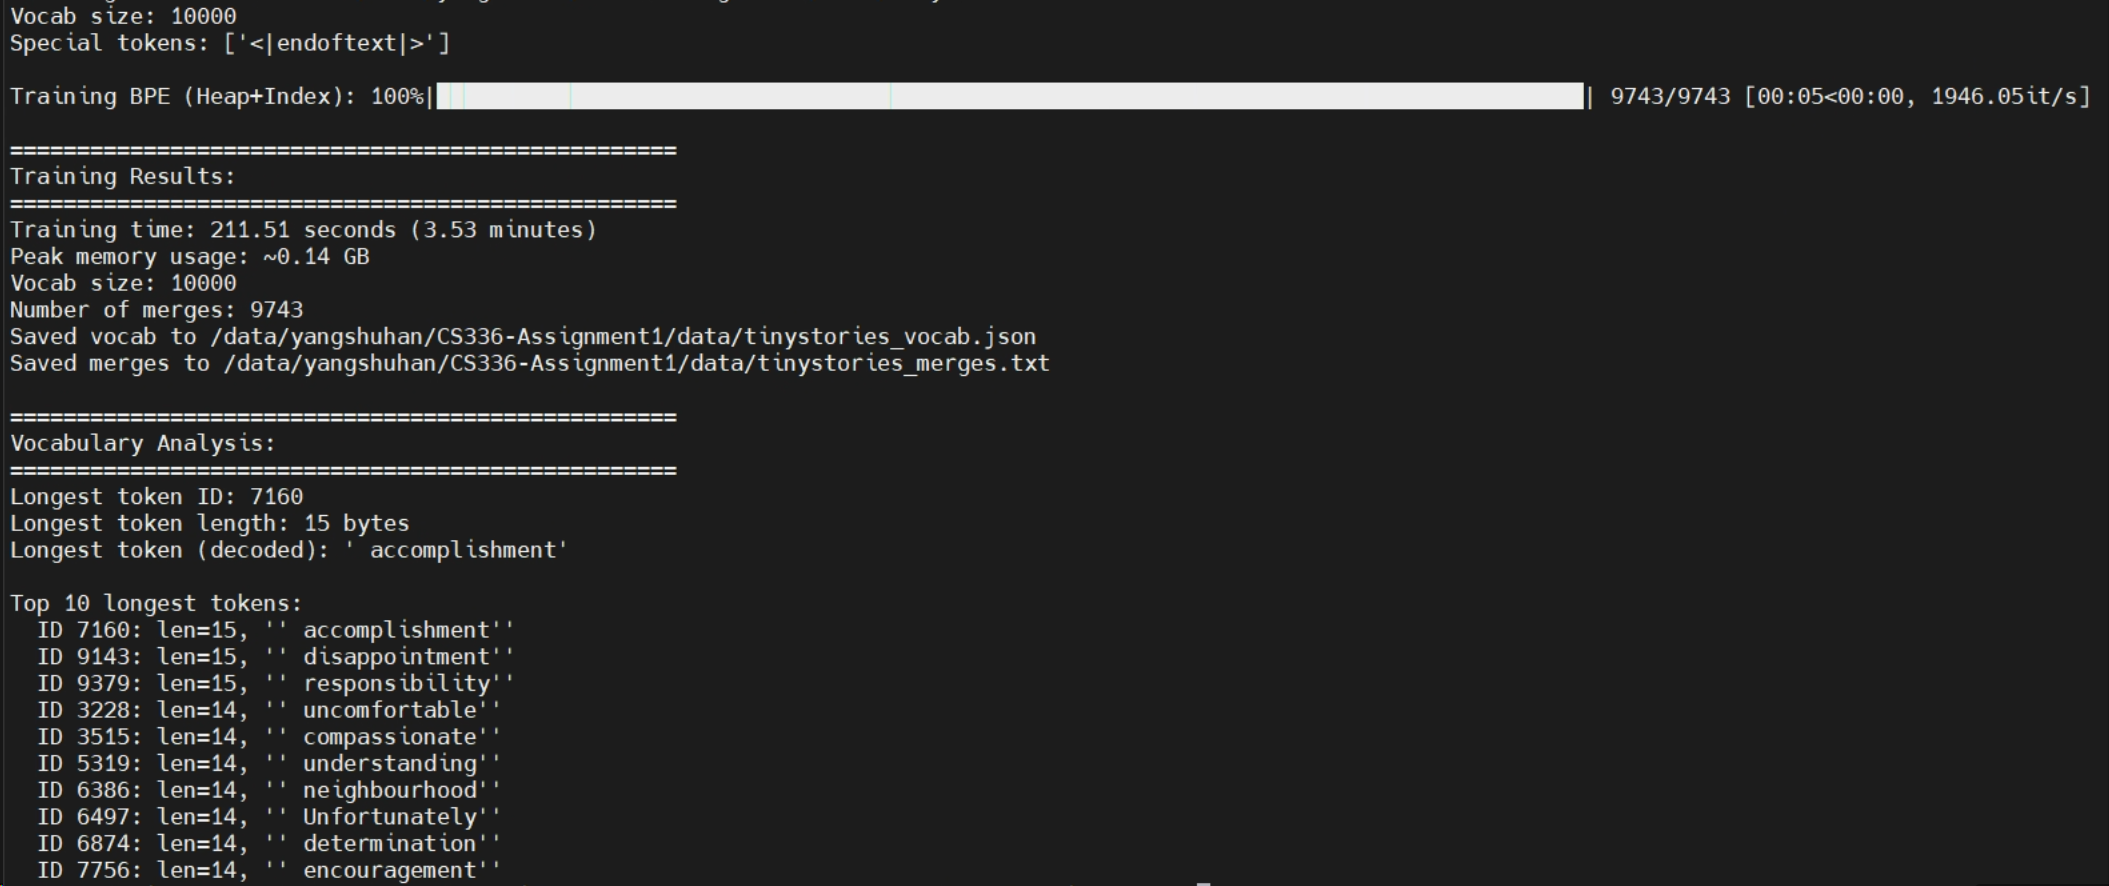

# 3.6 资源计算

### 单个 Block 的 MHA FLOPs 计算


| 操作 | FLOPs 公式 | 说明 |
|------|------------|------|
| Q 投影 | $2 \times seq\_len \times d\_model^2$ | 线性变换 |
| K 投影 | $2 \times seq\_len \times d\_model^2$ | 线性变换 |
| V 投影 | $2 \times seq\_len \times d\_model^2$ | 线性变换 |
| Q @ Kᵀ | $2 \times seq\_len^2 \times d\_model$ | 注意力分数计算 |
| Attn @ V | $2 \times seq\_len^2 \times d\_model$ | 注意力加权求和 |
| Output 投影 | $2 \times seq\_len \times d\_model^2$ | 输出变换 |

#### 总计公式
$$
\text{FLOPs}_{MHA} = 8 \times seq\_len \times d\_model^2 + 4 \times seq\_len^2 \times d\_model
$$

### 单个 Block 的 FFN FLOPs 计算




| 操作 | FLOPs 公式 | 说明 |
|------|------------|------|
| $xW_1$ | $2 \times seq\_len \times d\_model \times d\_ff$ | 第一层线性变换 |
| $xW_3$ | $2 \times seq\_len \times d\_model \times d\_ff$ | 第二层线性变换（SwiGLU结构） |
| $(\cdot)W_2$ | $2 \times seq\_len \times d\_ff \times d\_model$ | 输出投影 |

#### 总计公式

$$
\text{FLOPs}_{FFN} = 6 \times seq\_len \times d\_model \times d\_ff
$$


### 完整 Transformer FLOPs 计算




#### 单个 Transformer Block FLOPs

#### MHA 部分
$$
\text{FLOPs}_{MHA} = 8 \times seq\_len \times d\_model^2 + 4 \times seq\_len^2 \times d\_model
$$

#### FFN 部分
$$
\text{FLOPs}_{FFN} = 6 \times seq\_len \times d\_model \times d\_ff
$$

#### 单个 Block 总计
$$
\text{FLOPs}_{block} = 8 \times seq\_len \times d\_model^2 + 4 \times seq\_len^2 \times d\_model + 6 \times seq\_len \times d\_model \times d\_ff
$$

#### 所有 Transformer Blocks（48层）
$$
\text{FLOPs}_{blocks} = 48 \times (8 \times seq\_len \times d\_model^2 + 4 \times seq\_len^2 \times d\_model + 6 \times seq\_len \times d\_model \times d\_ff)
$$

#### Output Linear 层
$$
\text{FLOPs}_{output} = 2 \times seq\_len \times d\_model \times vocab\_size
$$

#### 总 FLOPs
$$
\begin{aligned}
\text{FLOPs}_{total} &= 48 \times (8 \times seq\_len \times d\_model^2 + 4 \times seq\_len^2 \times d\_model + 6 \times seq\_len \times d\_model \times d\_ff) \\
&\quad + 2 \times seq\_len \times d\_model \times vocab\_size
\end{aligned}
$$

## (a) 参数量和内存

### GPT-2 XL 参数量计算

### 各模块参数量

| 模块 | 参数量计算公式 | 参数数量 |
|------|--------------|----------|
| Token Embedding | $vocab\_size \times d\_model$ | $50257 \times 1600 = 80,411,200$ |
| 每个 Block 的 MHA | $4 \times d\_model^2$ | $4 \times 1600^2 = 10,240,000$ |
| 每个 Block 的 FFN | $3 \times d\_model \times d\_ff$ | $3 \times 1600 \times 6400 = 30,720,000$ |
| 每个 Block 的 RMSNorm (×2) | $2 \times d\_model$ | $2 \times 1600 = 3,200$ |
| Final RMSNorm | $d\_model$ | $1,600$ |
| Output Linear | $d\_model \times vocab\_size$ | $1600 \times 50257 = 80,411,200$ |

### 总参数量计算

$$
\begin{aligned}
\text{总参数量} &= \text{Token Embedding} + 48 \times (\text{MHA} + \text{FFN} + \text{RMSNorm}) + \text{Final RMSNorm} + \text{Output Linear} \\
&= 80,411,200 + 48 \times (10,240,000 + 30,720,000 + 3,200) + 1,600 + 80,411,200 \\
&\approx \textbf{1.56B 参数}
\end{aligned}
$$

### 内存占用

- 单精度 (float32)：每个参数 4 bytes
- 总内存：$1.56 \times 10^9 \times 4 \text{ bytes} \approx \textbf{6.24 GB}$

## (b) 矩阵乘法列表和总 FLOPs


| 组件 | 矩阵乘法 | FLOPs |
|------|----------|-------|
| MHA: Q 投影 | $(seq, d\_model) \times (d\_model, d\_model)$ | $2 \times 1024 \times 1600^2$ |
| MHA: K 投影 | 同上 | $2 \times 1024 \times 1600^2$ |
| MHA: V 投影 | 同上 | $2 \times 1024 \times 1600^2$ |
| MHA: Q @ K^T | $(seq, d\_head) \times (d\_head, seq) \times num\_heads$ | $2 \times 1024^2 \times 1600$ |
| MHA: Attn @ V | $(seq, seq) \times (seq, d\_head) \times num\_heads$ | $2 \times 1024^2 \times 1600$ |
| MHA: Output 投影 | $(seq, d\_model) \times (d\_model, d\_model)$ | $2 \times 1024 \times 1600^2$ |
| FFN: xW1 | $(seq, d\_model) \times (d\_model, d\_ff)$ | $2 \times 1024 \times 1600 \times 6400$ |
| FFN: xW3 | 同上 | $2 \times 1024 \times 1600 \times 6400$ |
| FFN: ·W2 | $(seq, d\_ff) \times (d\_ff, d\_model)$ | $2 \times 1024 \times 6400 \times 1600$ |
| Output Linear | $(seq, d\_model) \times (d\_model, vocab)$ | $2 \times 1024 \times 1600 \times 50257$ |

### 总 FLOPs

$$
48 \times (8 \times 1024 \times 1600^2 + 4 \times 1024^2 \times 1600 + 6 \times 1024 \times 1600 \times 6400) + 2 \times 1024 \times 1600 \times 50257
$$

$$
\approx \textbf{1.83 TFLOPs}

## (c) 哪部分消耗最多 FLOPs？



根据计算分析，GPT-2 XL 在推理过程中各模块的FLOPs分布如下：

| 组件模块 | FLOPs 占比 | 详细说明 |
|----------|------------|----------|
| **FFN 层** | **~54%** | 占比最高，主要由三个大矩阵乘法组成：<br>• $2 \times 1024 \times 1600 \times 6400$ (xW1)<br>• $2 \times 1024 \times 1600 \times 6400$ (xW3)<br>• $2 \times 1024 \times 6400 \times 1600$ (·W2) |
| **MHA 投影层** | **~28%** | 包括 Q、K、V 输入投影和输出投影：<br>• $4 \times (2 \times 1024 \times 1600^2)$ |
| **Attention 计算** | **~12%** | 注意力机制的核心计算：<br>• $2 \times 1024^2 \times 1600$ (Q@Kᵀ)<br>• $2 \times 1024^2 \times 1600$ (Attn@V) |
| **Output Linear** | **~6%** | 最后的输出层：<br>• $2 \times 1024 \times 1600 \times 50257$ |


## (d) 不同 GPT-2 模型的对比


### GPT-2 系列模型 FLOPs 与计算分布分析

| 模型 | 层数 | d_model | heads | d_ff | 总 FLOPs | FFN 占比 | Attention 占比 |
|------|------|---------|-------|------|----------|----------|----------------|
| GPT-2 Small | 12 | 768 | 12 | 3072 | ~109 GFLOPs | ~54% | ~13% |
| GPT-2 Medium | 24 | 1024 | 16 | 4096 | ~366 GFLOPs | ~54% | ~13% |
| GPT-2 Large | 36 | 1280 | 20 | 5120 | ~838 GFLOPs | ~54% | ~12% |
| GPT-2 XL | 48 | 1600 | 25 | 6400 | ~1.83 TFLOPs | ~54% | ~12% |



## (e)：context_length 增加到 16,384



### GPT-2 XL 模型在 seq_len = 16,384 时的 FLOPs 计算

#### 计算公式
$$
\text{FLOPs} = 48 \times (8 \times 16384 \times 1600^2 + 4 \times 16384^2 \times 1600 + 6 \times 16384 \times 1600 \times 6400) + 2 \times 16384 \times 1600 \times 50257
$$

#### 计算结果
$$
\approx \textbf{84.5 × 10¹² FLOPs (84.5 TFLOPs)}
$$

#### 对比分析
相比原来的 4.35 TFLOPs，增加了约 **19.4 倍**。

#### 组件占比变化

| 组件 | seq=1024 占比 | seq=16384 占比 |
|------|---------------|----------------|
| MHA 投影 | 23.1% | 14.7% |
| Attention (Q@K^T + Attn@V) | 4.1% | 40.3% |
| FFN | 72.4% | 44.7% |
| Output | 0.4% | 0.3% |

#### 结论

当 context_length 增加 16 倍时，**Attention 计算变成主要瓶颈**（从 4% 增加到 40%）。这是因为 Attention 的复杂度是 $O(\text{seq}^2)$，而其他组件是 $O(\text{seq})$。

这就是为什么长序列模型需要各种 **Efficient Attention 方法**（如 Flash Attention、Sparse Attention 等）。

第二步：展开公式
Softmax 的完整形式：
$$\text{softmax}(o)[k] = \frac{\exp(o[k])}{\sum_{j} \exp(o[j])}$$

代入 $-\log$：
$$-\log \text{softmax}(o)[k] = -\log \frac{\exp(o[k])}{\sum_{j} \exp(o[j])}$$

用 $\log \frac{a}{b} = \log a - \log b$：
$$= -\left(\log \exp(o[k]) - \log \sum_{j} \exp(o[j])\right)$$

$$= -o[k] + \log \sum_{j} \exp(o[j])$$

最终公式：
$$\ell = -o[target] + \log \sum_{j} \exp(o[j])$$




数值稳定性推导
设 $m = \max(o)$

$$\log \sum_j \exp(o[j] - m) = \log \sum_j \frac{\exp(o[j])}{\exp(m)}$$

$$= \log \frac{\sum_j \exp(o[j])}{\exp(m)}$$

$$= \log \sum_j \exp(o[j]) - \log \exp(m)$$

$$= \log \sum_j \exp(o[j]) - m$$

所以：
$$\log \sum_j \exp(o[j]) = m + \log \sum_j \exp(o[j] - m)$$

第四步：最终稳定的公式
把这个代入我们的 cross entropy：

$$\ell = -o[target] + \log \sum_{j} \exp(o[j])$$

$$= -o[target] + m + \log \sum_{j} \exp(o[j] - m)$$

也可以写成：

$$= -(o[target] - m) + \log \sum_{j} \exp(o[j] - m)$$

# 4.2 学习率的探究

In [1]:
from collections.abc import Callable, Iterable
from typing import Optional
import torch
import math

class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr}
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        loss = None if closure is None else closure()  # 兼容API（可选：重新计算loss）
        # 遍历每个参数组（param_groups）
        for group in self.param_groups:
            lr = group["lr"]  # 获取当前组的学习率
            
            # 遍历组内每个参数
            for p in group["params"]:
                if p.grad is None:  # 如果参数没有梯度，跳过
                    continue
                
                # 获取参数的“状态（state）”：存储迭代次数t
                state = self.state[p]
                t = state.get("t", 0)  # 初始t=0，之后每次迭代+1
                
                grad = p.grad.data  # 获取参数的梯度
                # 按照公式更新参数（in-place修改p.data）
                p.data -= lr / math.sqrt(t + 1) * grad
                
                state["t"] = t + 1  # 迭代次数+1
        return loss


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\anaconda\envs\pytorch\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\anaconda\envs\pytorch\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\anaconda\envs\pytorch\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "d:\anaconda\envs\pytorch\Lib\site-pack


学习率 = 10.0
  Iteration 0: x = -190.000000, loss = 100.000000
  Iteration 1: x = 2497.005859, loss = 36100.000000
  Iteration 2: x = -26335.935547, loss = 6235038.500000
  Iteration 3: x = 237023.406250, loss = 693581504.000000
  Iteration 4: x = -1882978.375000, loss = 56180097024.000000
  Iteration 5: x = 13491476.000000, loss = 3545607438336.000000
  Iteration 6: x = -88494496.000000, loss = 182019925475328.000000
  Iteration 7: x = 537256064.000000, loss = 7831275863801856.000000
  Iteration 8: x = -3044450816.000000, loss = 288644067401662464.000000
  Iteration 9: x = 16210348032.000000, loss = 9268680712012169216.000000

学习率 = 100.0
  Iteration 0: x = -1990.000000, loss = 100.000000
  Iteration 1: x = 279438.500000, loss = 3960100.000000
  Iteration 2: x = -31987340.000000, loss = 78085873664.000000
  Iteration 3: x = 3166746624.000000, loss = 1023189924708352.000000
  Iteration 4: x = -280075698176.000000, loss = 10028283817619357696.000000
  Iteration 5: x = 22588008955904.0000

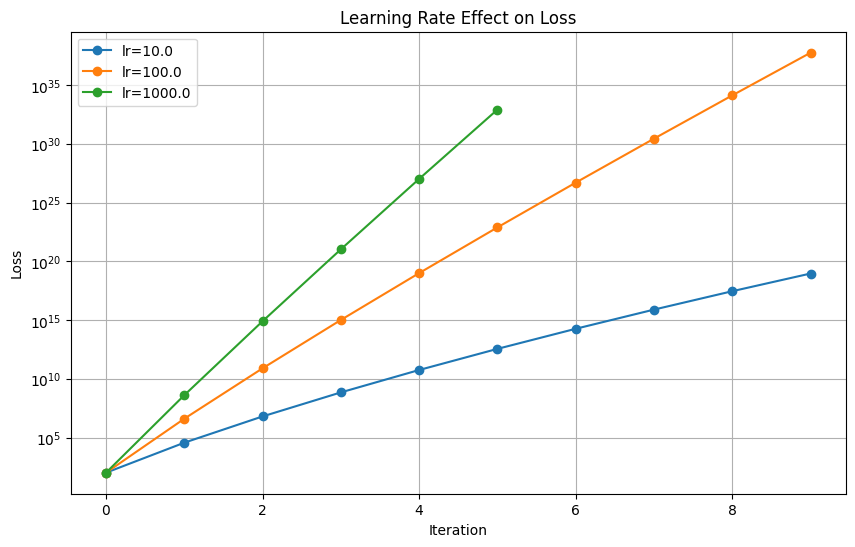

In [3]:
import torch
import matplotlib.pyplot as plt

# 实验：测试不同学习率对训练的影响
def experiment_learning_rates():
    learning_rates = [1e1, 1e2, 1e3]  # 10, 100, 1000
    num_iterations = 10
    
    results = {}  # 存储每个学习率的loss历史
    
    for lr in learning_rates:
        print(f"\n学习率 = {lr}")
        
        # 1. 初始化参数
        x = torch.tensor([10.0], requires_grad=True)
        
        # 2. 创建优化器
        optimizer = SGD([x], lr=lr)
        
        # 3. 记录loss历史
        loss_history = []
        
        # 4. 训练10步
        for i in range(num_iterations):
            # 清空梯度
            optimizer.zero_grad()
            
            # 计算损失：f(x) = x^2
            loss = x ** 2
            
            # 反向传播
            loss.backward()
            
            # 更新参数
            optimizer.step()
            
            # 记录loss
            loss_value = loss.item()
            loss_history.append(loss_value)
            
            print(f"  Iteration {i}: x = {x.item():.6f}, loss = {loss_value:.6f}")
        
        results[lr] = loss_history
    
    # 可视化结果
    plt.figure(figsize=(10, 6))
    for lr, loss_history in results.items():
        plt.plot(range(num_iterations), loss_history, marker='o', label=f'lr={lr}')
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Learning Rate Effect on Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # 使用对数坐标，方便观察
    plt.show()
    
    return results

# 运行实验
results = experiment_learning_rates()


# 4.3 AdamW训练资源计算


## 问题 (a)：AdamW 峰值内存计算

### 内存组成
设总参数量为 $P$（对于 GPT-2 XL，$P ≈ 1.56B$）

| 组件 | 内存占用 |
|------|----------|
| 参数（Parameters） | $P × 4$ bytes |
| 梯度（Gradients） | $P × 4$ bytes |
| 优化器状态（Optimizer State） | |
| - exp_avg (第一动量) | $P × 4$ bytes |
| - exp_avg_sq (第二动量) | $P × 4$ bytes |
| 激活值（Activations） | $batch\_size × context\_length × d\_model × num\_layers × k$ bytes |

其中 $k$ 取决于具体实现，题目简化只考虑主要组件。

### 总内存（不含激活值）
$$
\text{Memory} = 4P \times 4 \text{ bytes} = 16P \text{ bytes}
$$

对于 GPT-2 XL ($P = 1.56B$)：
$$
\text{Memory} = 16 \times 1.56 \times 10^9 \times 4 = 24.96 \text{ GB}
$$

### 激活值内存
激活值取决于 batch_size。对于题目提到的组件（RMSNorm、MHA、FFN、output embedding、cross-entropy），每层大约需要存储：

- RMSNorm 输出：$batch\_size × seq\_len × d\_model$
- MHA 中间结果（Q, K, V, attention scores）：$batch\_size × seq\_len × d\_model$ 及 $batch\_size × num\_heads × seq\_len × seq\_len$
- FFN 中间结果：$batch\_size × seq\_len × d\_ff$

粗略估计单层激活：$batch\_size × seq\_len × (2 × d\_model + d\_ff + seq\_len × num\_heads) × 4$ bytes

### 代数表达式
$$
\text{Memory} = 16P + \text{batch\_size} \times \text{context\_length} \times f(\text{vocab\_size}, \text{d\_model}, \text{num\_layers}, \text{num\_heads})
$$

其中 $f$ 是与模型架构相关的函数，主要项包括：

- 每层的激活：$O(batch\_size × context\_length × (d\_model + d\_ff))$
- attention scores：$O(batch\_size × num\_heads × context\_length^2)$

---

## 问题 (b)：最大 batch_size（80GB 内存限制）

给定 80GB 内存，求最大 batch_size。

### 简化计算
假设激活值主要由 FFN 中间层主导：
$$
\text{Activations} \approx \text{batch\_size} \times \text{context\_length} \times \text{d\_ff} \times \text{num\_layers} \times 4
$$

总内存：
$$
80 \text{ GB} = 16P + \text{batch\_size} \times 1024 \times 6400 \times 48 \times 4
$$

$$
80 \times 10^9 = 24.96 \times 10^9 + \text{batch\_size} \times 1024 \times 6400 \times 48 \times 4
$$

$$
55.04 \times 10^9 = \text{batch\_size} \times 1.258 \times 10^9
$$

$$
\text{batch\_size} \approx 43
$$

### 表达式形式
$$
\text{batch\_size} = \frac{80 \text{ GB} - 16P}{\text{context\_length} \times k}
$$

其中 $k$ 是与模型大小相关的常数。

---

## 问题 (c)：一步 AdamW 的 FLOPs

AdamW 的每个参数更新需要：

- 更新 $m$：$2P$ FLOPs（乘法 + 加法）
- 更新 $v$：$3P$ FLOPs（平方 + 乘法 + 加法）
- 计算更新值：$3P$ FLOPs（开方 + 除法 + 乘法）
- 更新参数：$2P$ FLOPs（乘法 + 减法）
- Weight decay：$2P$ FLOPs

总计：约 $12P$ FLOPs 每步

对于 GPT-2 XL ($P = 1.56B$)：
$$
\text{FLOPs} \approx 12 \times 1.56 \times 10^9 = 18.72 \text{ GFLOPs}
$$

相比前向传播的 1.83 TFLOPs，优化器更新几乎可以忽略不计（约 1%）。

---

## 问题 (d)：训练时间估算

假设：

- 50% MFU（Model FLOPs Utilization）
- A100 理论峰值：19.5 teraFLOP/s (float32)
- 实际算力：$19.5 × 0.5 = 9.75$ teraFLOP/s
- Batch size：1024
- 训练步数：400K steps

### 每步总 FLOPs
- 前向：$1.83$ TFLOPs $×$ batch_size = $1.83T × 1024$
- 反向：约 $2×$ 前向 = $3.66T × 1024$
- 优化器：可忽略
- 总计每步：$(1.83 + 3.66) × 1024 ≈ 5.62$ PFLOPs

### 训练时间
$$
\text{Time} = \frac{5.62 \times 10^{15} \times 400,000}{9.75 \times 10^{12}} \approx 230.5 \times 10^6 \text{ 秒}
$$

$$
\approx 2,668 \text{ 天} \approx 7.3 \text{ 年}
$$

**实际上需要多卡并行训练！**